# COGS 181 Final Project

## Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
summary_stats = []
all_losses = {}

In [4]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

classes = trainset.classes


100%|██████████| 170M/170M [00:12<00:00, 13.5MB/s]


## Experiment 1: Baseline CNN

In [6]:
class BaselineCNN(nn.Module):
    def __init__(self):
        super(BaselineCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = BaselineCNN().to(device)

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
train_losses = []
epochs = 10

start_time = time.time()

for epoch in range(epochs):
    running_loss = 0.0
    model.train()
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(trainloader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

end_time = time.time()
train_time = end_time - start_time

print(f"Training Time: {train_time:.2f} seconds")

Epoch 1/10, Loss: 1.3421
Epoch 2/10, Loss: 0.9634
Epoch 3/10, Loss: 0.8026
Epoch 4/10, Loss: 0.6879
Epoch 5/10, Loss: 0.5892
Epoch 6/10, Loss: 0.5018
Epoch 7/10, Loss: 0.4195
Epoch 8/10, Loss: 0.3377
Epoch 9/10, Loss: 0.2723
Epoch 10/10, Loss: 0.2155
Training Time: 149.94 seconds


In [9]:
correct = 0
total = 0
model.eval()

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 72.11%


In [10]:
summary_stats.append({
    "Model": "Baseline CNN",
    "Params": count_parameters(model),
    "Activation": "ReLU",
    "Optimizer": "Adam",
    "Accuracy (%)": accuracy,
    "Train Time (s)": round(train_time, 2),
    "Final Loss": round(train_losses[-1], 4)
})

all_losses["Baseline CNN"] = train_losses

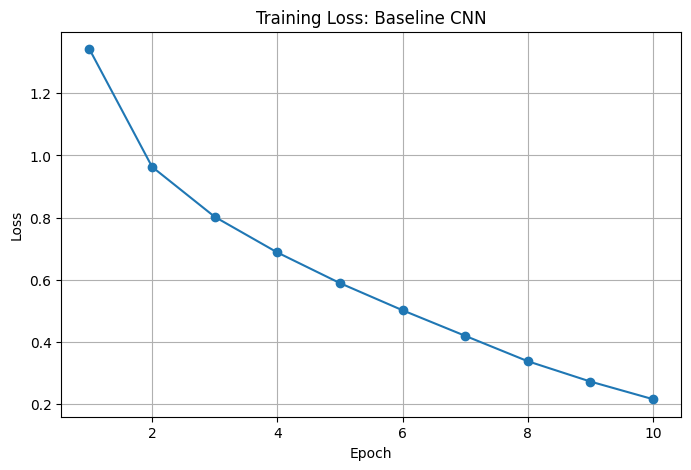

In [11]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs+1), train_losses, marker='o')
plt.title("Training Loss: Baseline CNN")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

## Experiment 2: Baseline CNN + Batch Normalization + Dropout

In [12]:
class BaselineCNN_BN_Dropout(nn.Module):
    def __init__(self):
        super(BaselineCNN_BN_Dropout, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = torch.flatten(x, 1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

model_bn_dropout = BaselineCNN_BN_Dropout().to(device)

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_bn_dropout.parameters(), lr=0.001)

In [14]:
train_losses_bn_dropout = []
epochs = 10

start_time = time.time()

for epoch in range(epochs):
    running_loss = 0.0
    model_bn_dropout.train()
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model_bn_dropout(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(trainloader)
    train_losses_bn_dropout.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

end_time = time.time()
train_time_bn_dropout = end_time - start_time

print(f"Training Time: {train_time_bn_dropout:.2f} seconds")

Epoch 1/10, Loss: 1.6210
Epoch 2/10, Loss: 1.3571
Epoch 3/10, Loss: 1.2604
Epoch 4/10, Loss: 1.1945
Epoch 5/10, Loss: 1.1506
Epoch 6/10, Loss: 1.1007
Epoch 7/10, Loss: 1.0656
Epoch 8/10, Loss: 1.0366
Epoch 9/10, Loss: 1.0057
Epoch 10/10, Loss: 0.9842
Training Time: 145.76 seconds


In [15]:
correct = 0
total = 0
model_bn_dropout.eval()

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model_bn_dropout(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy_bn_dropout = 100 * correct / total
print(f"Test Accuracy: {accuracy_bn_dropout:.2f}%")

Test Accuracy: 71.49%


In [16]:
summary_stats.append({
    "Model": "Baseline CNN (BN + Dropout)",
    "Params": count_parameters(model_bn_dropout),
    "Activation": "ReLU",
    "Optimizer": "Adam",
    "Accuracy (%)": accuracy_bn_dropout,
    "Train Time (s)": round(train_time_bn_dropout, 2),
    "Final Loss": round(train_losses_bn_dropout[-1], 4)
})

all_losses["Baseline CNN (BN + Dropout)"] = train_losses_bn_dropout

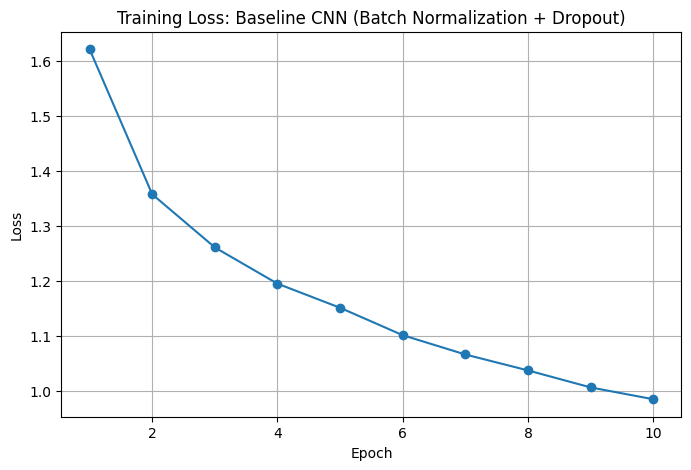

In [17]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs+1), train_losses_bn_dropout, marker='o')
plt.title("Training Loss: Baseline CNN (Batch Normalization + Dropout)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

## Experiment 3: Deeper Baseline CNN

In [18]:
class BaselineCNN_Deeper(nn.Module):
    def __init__(self):
        super(BaselineCNN_Deeper, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(128 * 2 * 2, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model_deeper = BaselineCNN_Deeper().to(device)

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_deeper.parameters(), lr=0.001)

In [20]:
train_losses_deeper = []
epochs = 10

start_time = time.time()

for epoch in range(epochs):
    running_loss = 0.0
    model_deeper.train()
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model_deeper(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(trainloader)
    train_losses_deeper.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

end_time = time.time()
train_time_deeper = end_time - start_time

print(f"Training Time: {train_time_deeper:.2f} seconds")

Epoch 1/10, Loss: 1.4569
Epoch 2/10, Loss: 0.9828
Epoch 3/10, Loss: 0.7744
Epoch 4/10, Loss: 0.6413
Epoch 5/10, Loss: 0.5358
Epoch 6/10, Loss: 0.4461
Epoch 7/10, Loss: 0.3635
Epoch 8/10, Loss: 0.2935
Epoch 9/10, Loss: 0.2384
Epoch 10/10, Loss: 0.1985
Training Time: 149.65 seconds


In [21]:
correct = 0
total = 0
model_deeper.eval()

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model_deeper(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy_deeper = 100 * correct / total
print(f"Test Accuracy: {accuracy_deeper:.2f}%")

Test Accuracy: 75.26%


In [22]:
summary_stats.append({
    "Model": "Deeper Baseline CNN",
    "Params": count_parameters(model_deeper),
    "Activation": "ReLU",
    "Optimizer": "Adam",
    "Accuracy (%)": accuracy_deeper,
    "Train Time (s)": round(train_time_deeper, 2),
    "Final Loss": round(train_losses_deeper[-1], 4)
})

all_losses["Deeper Baseline CNN"] = train_losses_deeper

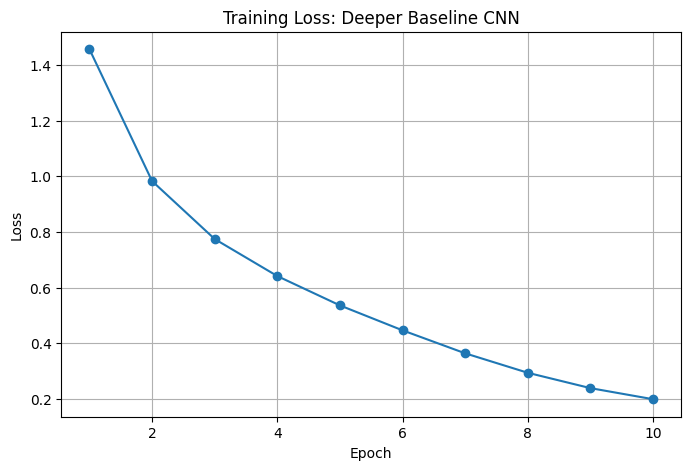

In [23]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs+1), train_losses_deeper, marker='o')
plt.title("Training Loss: Deeper Baseline CNN")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

## Experiment 4: ResNet18 (ReLU + Adam)

In [24]:
resnet18 = models.resnet18(pretrained=False)

num_features = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_features, 10)

resnet18 = resnet18.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.parameters(), lr=0.001)

In [26]:
train_losses_resnet = []
epochs = 10

start_time = time.time()

for epoch in range(epochs):
    running_loss = 0.0
    resnet18.train()
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet18(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(trainloader)
    train_losses_resnet.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

end_time = time.time()
train_time_resnet = end_time - start_time

print(f"Training Time: {train_time_resnet:.2f} seconds")

Epoch 1/10, Loss: 1.3735
Epoch 2/10, Loss: 0.9766
Epoch 3/10, Loss: 0.7948
Epoch 4/10, Loss: 0.6735
Epoch 5/10, Loss: 0.5746
Epoch 6/10, Loss: 0.4730
Epoch 7/10, Loss: 0.3924
Epoch 8/10, Loss: 0.3213
Epoch 9/10, Loss: 0.2603
Epoch 10/10, Loss: 0.2174
Training Time: 242.34 seconds


In [27]:
correct = 0
total = 0
resnet18.eval()

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy_resnet = 100 * correct / total
print(f"Test Accuracy: {accuracy_resnet:.2f}%")

Test Accuracy: 76.57%


In [28]:
summary_stats.append({
    "Model": "ResNet18",
    "Params": count_parameters(resnet18),
    "Activation": "ReLU",
    "Optimizer": "Adam",
    "Accuracy (%)": accuracy_resnet,
    "Train Time (s)": round(train_time_resnet, 2),
    "Final Loss": round(train_losses_resnet[-1], 4)
})

all_losses["ResNet18"] = train_losses_resnet

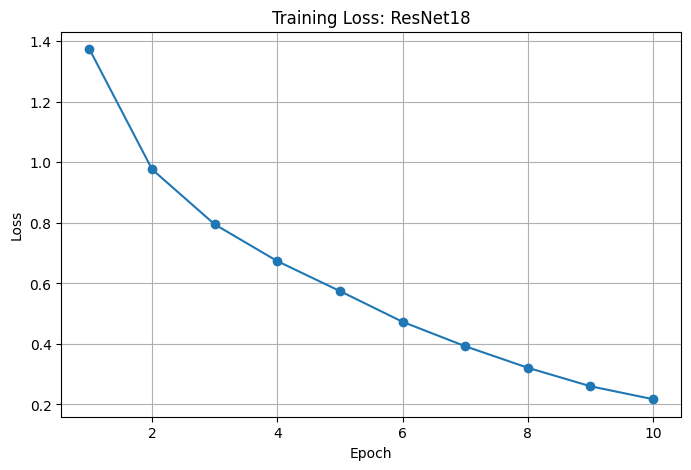

In [29]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs+1), train_losses_resnet, marker='o')
plt.title("Training Loss: ResNet18")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

## Experiment 5: VGG11

In [30]:
vgg = models.vgg11(pretrained=False)

vgg.classifier[6] = nn.Linear(4096, 10)

vgg = vgg.to(device)

In [31]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg.parameters(), lr=0.001)

In [32]:
train_losses_vgg = []
epochs = 10

start_time = time.time()

for epoch in range(epochs):
    running_loss = 0.0
    vgg.train()
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = vgg(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(trainloader)
    train_losses_vgg.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

end_time = time.time()
train_time_vgg = end_time - start_time

print(f"Training Time: {train_time_vgg:.2f} seconds")

Epoch 1/10, Loss: 2.3425
Epoch 2/10, Loss: 2.3028
Epoch 3/10, Loss: 2.3028
Epoch 4/10, Loss: 2.3028
Epoch 5/10, Loss: 2.3028
Epoch 6/10, Loss: 2.3028
Epoch 7/10, Loss: 2.3027
Epoch 8/10, Loss: 2.3027
Epoch 9/10, Loss: 2.3027
Epoch 10/10, Loss: 2.3027
Training Time: 618.86 seconds


In [33]:
correct = 0
total = 0
vgg.eval()

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy_vgg = 100 * correct / total
print(f"Test Accuracy: {accuracy_vgg:.2f}%")

Test Accuracy: 10.00%


In [34]:
summary_stats.append({
    "Model": "VGG11",
    "Params": count_parameters(vgg),
    "Activation": "ReLU",
    "Optimizer": "Adam",
    "Accuracy (%)": accuracy_vgg,
    "Train Time (s)": round(train_time_vgg, 2),
    "Final Loss": round(train_losses_vgg[-1], 4)
})

all_losses["VGG11"] = train_losses_vgg

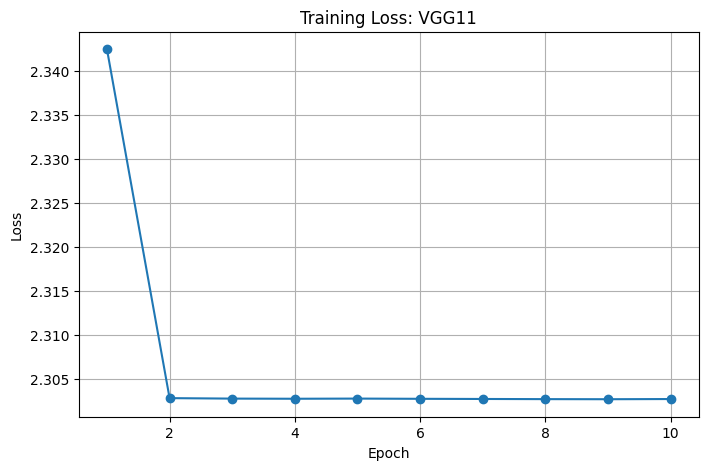

In [35]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs+1), train_losses_vgg, marker='o')
plt.title("Training Loss: VGG11")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

## Experiment 6: ResNet18 (ReLU + SGD)

In [36]:
resnet18_sgd = models.resnet18(pretrained=False)

num_features = resnet18_sgd.fc.in_features
resnet18_sgd.fc = nn.Linear(num_features, 10)

resnet18_sgd = resnet18_sgd.to(device)

In [37]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18_sgd.parameters(), lr=0.001, momentum=0.9)

In [38]:
train_losses_resnet_sgd = []
epochs = 10

start_time = time.time()

for epoch in range(epochs):
    running_loss = 0.0
    resnet18_sgd.train()
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet18_sgd(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(trainloader)
    train_losses_resnet_sgd.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

end_time = time.time()
train_time_resnet_sgd = end_time - start_time

print(f"Training Time: {train_time_resnet_sgd:.2f} seconds")

Epoch 1/10, Loss: 1.5766
Epoch 2/10, Loss: 1.2128
Epoch 3/10, Loss: 1.0086
Epoch 4/10, Loss: 0.8507
Epoch 5/10, Loss: 0.7083
Epoch 6/10, Loss: 0.5820
Epoch 7/10, Loss: 0.4648
Epoch 8/10, Loss: 0.3732
Epoch 9/10, Loss: 0.2967
Epoch 10/10, Loss: 0.2288
Training Time: 233.09 seconds


In [39]:
correct = 0
total = 0
resnet18_sgd.eval()

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18_sgd(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy_resnet_sgd = 100 * correct / total
print(f"Test Accuracy: {accuracy_resnet_sgd:.2f}%")

Test Accuracy: 64.96%


In [40]:
summary_stats.append({
    "Model": "ResNet18 (SGD)",
    "Params": count_parameters(resnet18_sgd),
    "Activation": "ReLU",
    "Optimizer": "SGD",
    "Accuracy (%)": accuracy_resnet_sgd,
    "Train Time (s)": round(train_time_resnet_sgd, 2),
    "Final Loss": round(train_losses_resnet_sgd[-1], 4)
})

all_losses["ResNet18 (SGD)"] = train_losses_resnet_sgd

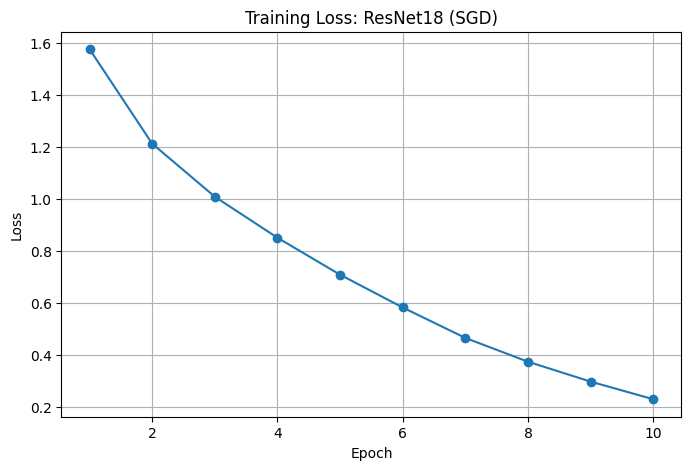

In [41]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs+1), train_losses_resnet_sgd, marker='o')
plt.title("Training Loss: ResNet18 (SGD)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

## Experiment 7: ResNet18 (LeakyReLU + Adam)

In [42]:
from torchvision.models.resnet import ResNet, BasicBlock

class ResNet18_LeakyReLU(ResNet):
    def __init__(self):
        super().__init__(block=BasicBlock, layers=[2, 2, 2, 2])
        self.fc = nn.Linear(512, 10)

    def _forward_impl(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.leaky_relu(x, negative_slope=0.01, inplace=True)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

resnet18_leaky = ResNet18_LeakyReLU().to(device)

In [43]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18_leaky.parameters(), lr=0.001)

In [44]:
train_losses_resnet_leaky = []
epochs = 10

start_time = time.time()

for epoch in range(epochs):
    running_loss = 0.0
    resnet18_leaky.train()
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet18_leaky(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(trainloader)
    train_losses_resnet_leaky.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

end_time = time.time()
train_time_resnet_leaky = end_time - start_time

print(f"Training Time: {train_time_resnet_leaky:.2f} seconds")

Epoch 1/10, Loss: 1.3842
Epoch 2/10, Loss: 0.9896
Epoch 3/10, Loss: 0.8160
Epoch 4/10, Loss: 0.6922
Epoch 5/10, Loss: 0.5916
Epoch 6/10, Loss: 0.4944
Epoch 7/10, Loss: 0.4138
Epoch 8/10, Loss: 0.3288
Epoch 9/10, Loss: 0.2659
Epoch 10/10, Loss: 0.2153
Training Time: 245.02 seconds


In [45]:
correct = 0
total = 0
resnet18_leaky.eval()

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18_leaky(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy_resnet_leaky = 100 * correct / total
print(f"Test Accuracy: {accuracy_resnet_leaky:.2f}%")

Test Accuracy: 75.82%


In [46]:
summary_stats.append({
    "Model": "ResNet18 (LeakyReLU)",
    "Params": count_parameters(resnet18_leaky),
    "Activation": "LeakyReLU",
    "Optimizer": "Adam",
    "Accuracy (%)": accuracy_resnet_leaky,
    "Train Time (s)": round(train_time_resnet_leaky, 2),
    "Final Loss": round(train_losses_resnet_leaky[-1], 4)
})

all_losses["ResNet18 (LeakyReLU)"] = train_losses_resnet_leaky

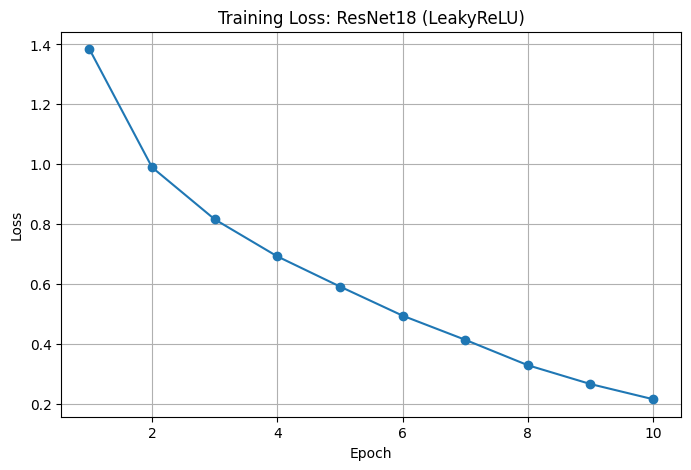

In [47]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs+1), train_losses_resnet_leaky, marker='o')
plt.title("Training Loss: ResNet18 (LeakyReLU)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

## Summary Stats

In [48]:
import pandas as pd

df_summary = pd.DataFrame(summary_stats)

df_summary = df_summary.sort_values(by="Accuracy (%)", ascending=False)

display(df_summary)

,Model,Params,Activation,Optimizer,Accuracy (%),Train Time (s),Final Loss
3,ResNet18,11181642,ReLU,Adam,76.57,242.34,0.2174
6,ResNet18 (LeakyReLU),11181642,LeakyReLU,Adam,75.82,245.02,0.2153
2,Deeper Baseline CNN,307786,ReLU,Adam,75.26,149.65,0.1985
0,Baseline CNN,545098,ReLU,Adam,72.11,149.94,0.2155
1,Baseline CNN (BN + Dropout),545290,ReLU,Adam,71.49,145.76,0.9842
5,ResNet18 (SGD),11181642,ReLU,SGD,64.96,233.09,0.2288
4,VGG11,128807306,ReLU,Adam,10.00,618.86,2.3027


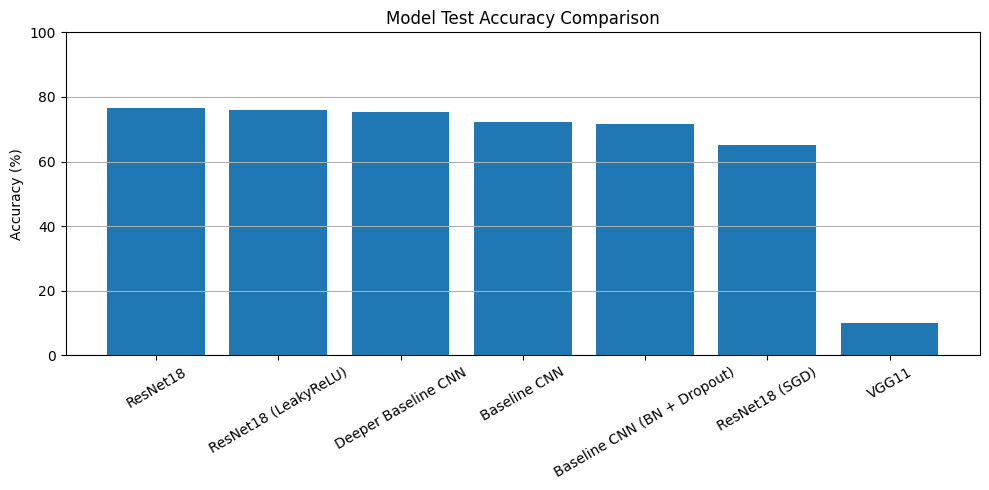

In [49]:
plt.figure(figsize=(10, 5))
plt.bar(df_summary["Model"], df_summary["Accuracy (%)"])
plt.title("Model Test Accuracy Comparison")
plt.ylabel("Accuracy (%)")
plt.xticks(rotation=30)
plt.ylim(0, 100)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

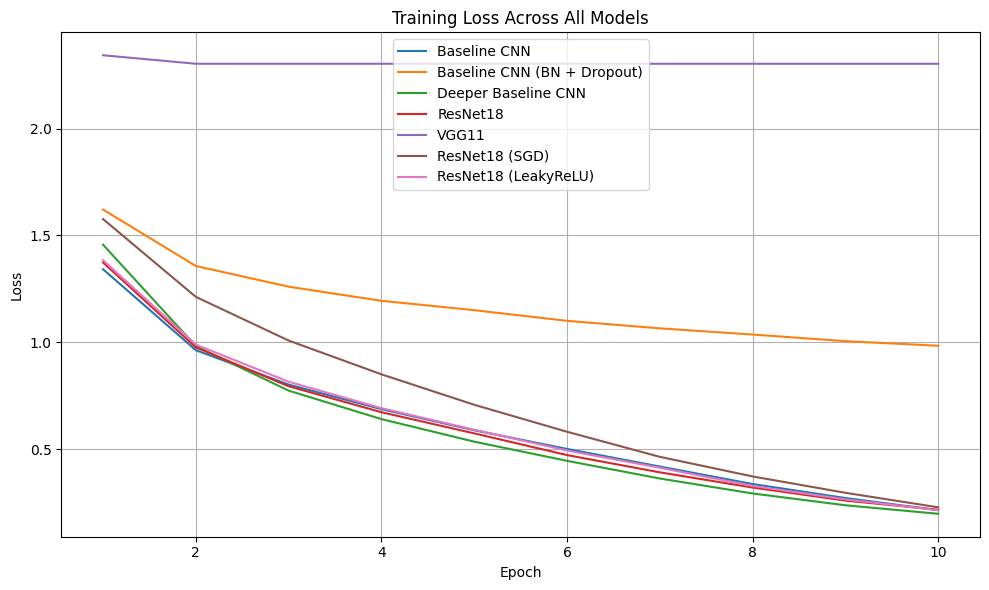

In [50]:
plt.figure(figsize=(10, 6))
for label, losses in all_losses.items():
    plt.plot(range(1, len(losses)+1), losses, label=label)
plt.title("Training Loss Across All Models")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()